# Finding Angle of Objects in Images
Anshul Gupta
16 June 2020

In [1]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

## Get Image
Uses images from powerpoint, all of which are supposedly aligned.

Images converted to grayscale to simplify process.

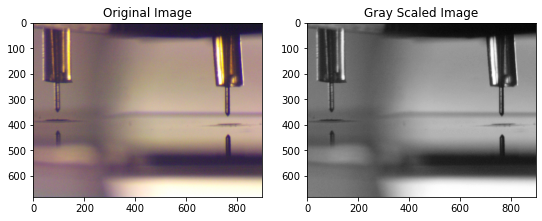

In [2]:
filename = "image.jpg"
img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale

fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
ax[0].set_title('Original Image')
ax[0].imshow(img)
ax[1].set_title('Gray Scaled Image')
ax[1].imshow(gray, cmap='gray')

## Finding Angle of Known Misalignment
In the upper right of the image, the base is very clearly not vertical. We will use that to test whether an angle can
 be detected.

### Crop Image to Area of Interest

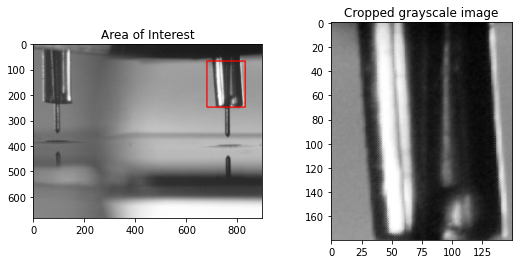

In [3]:
# To box area of interest
gray_boxed = cv2.cvtColor(np.array(gray), cv2.COLOR_GRAY2RGB)
cv2.rectangle(gray_boxed, (680, 70), (830, 250), (255, 0, 0), 4)

gray = gray[70:250, 680:830]  # Crop image

fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
ax[0].set_title('Area of Interest')
ax[0].imshow(gray_boxed)
ax[1].set_title('Cropped grayscale image')
ax[1].imshow(gray, cmap='gray')

### Find Edges
Finds the edges of the image using Canny Edge Detection in OpenCV. The only edges that matter are the left and right
most edges as they define the edge of the base.

Edges are put in Pandas Dataframe to make it easier.

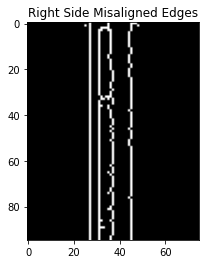

In [17]:
edges = cv2.Canny(gray, 100, 150)  # Find edges

df = pd.DataFrame(edges)  # Put in dataframe

fig, ax = plt.subplots()
ax.set_title('Right Side Misaligned Edges')
ax.imshow(edges, cmap='gray')

### Extract the Left Most Line
Using ```idxmax```, the first column with a non-zero value is returned for each row, which corresponds to the left most line.

The plot shows that the line is slanted. If the line was vertical, the plot would be flat.


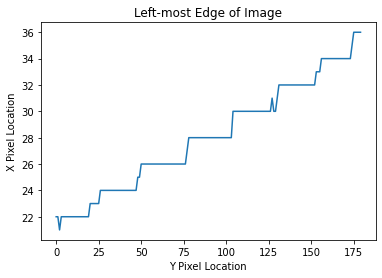

In [5]:
tmp = df.idxmax(axis=1)  # Get pixel locations for left most line

x = tmp.index.values  # y pixel locations
y = tmp.values  # x pixel locations

fig, ax = plt.subplots()
ax.set_title('Left-most Edge of Image')
ax.set_xlabel('Y Pixel Location')
ax.set_ylabel('X Pixel Location')
ax.plot(x, y)

### Calculate Actual Edge
Using Linear Regression on the edge, we can find the line that represents the actual edge of the object.

Text(0, 0.5, 'X Pixel Location')

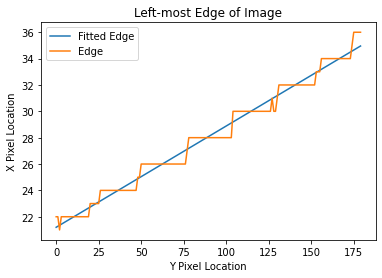

In [6]:
# Fit linear model
model = LinearRegression()
model.fit(x.reshape((-1, 1)), y.reshape((-1, 1)))

new_y = model.predict(x.reshape((-1, 1))).flatten()

fig, ax = plt.subplots()
ax.plot(x, new_y, label='Fitted Edge')
ax.plot(x, y, label='Edge')
ax.legend(loc='upper left')
ax.set_title('Left-most Edge of Image')
ax.set_xlabel('Y Pixel Location')
ax.set_ylabel('X Pixel Location')

### Get Angle from Slope
We now know the slope of the line, so from that we can calculate the angle of the line.

From this, we see that the base is 4.39° from being vertical.

In [7]:
print("Slope: ", model.coef_)
print("Angle: ", np.arctan(model.coef_), "radians")
print("Angle: ", np.degrees(np.arctan(model.coef_)), "degrees")

Slope:  [[0.07685217]]
Angle:  [[0.0767014]] radians
Angle:  [[4.39466635]] degrees


## Find Angle of Known Alignment
We will be using the right side still, but we will use the emitter instead, which should be aligned.

### Crop Image to Area of Interest

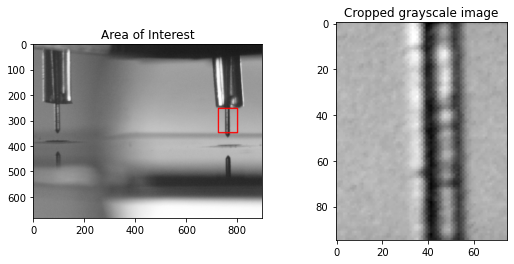

In [18]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Remake gray image
# To box area of interest
gray_boxed = cv2.cvtColor(np.array(gray), cv2.COLOR_GRAY2RGB)
cv2.rectangle(gray_boxed, (725, 255), (800, 350), (255, 0, 0), 4)

# gray = gray[255:350, 725:800]  # Crop image
gray = gray[240:335, 50:125]

fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
ax[0].set_title('Area of Interest')
ax[0].imshow(gray_boxed)
ax[1].set_title('Cropped grayscale image')
ax[1].imshow(gray, cmap='gray')

### Find Edges

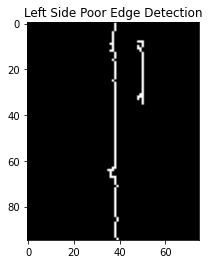

In [20]:
edges = cv2.Canny(gray, 100, 200)  # Find edges

df = pd.DataFrame(edges)  # Put in dataframe

fig, ax = plt.subplots()
ax.set_title('Left Side Poor Edge Detection')
ax.imshow(edges, cmap='gray')

### Extract the Left Most Line
The plot is completely flat, indicating that the emitter is perfectly vertical.


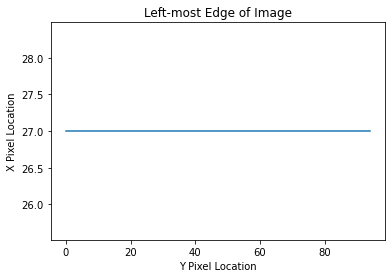

In [10]:
tmp = df.idxmax(axis=1)  # Get pixel locations for left most line

x = tmp.index.values  # y pixel locations
y = tmp.values  # x pixel locations

fig, ax = plt.subplots()
ax.set_title('Left-most Edge of Image')
ax.set_xlabel('Y Pixel Location')
ax.set_ylabel('X Pixel Location')
ax.plot(x, y)

### Calculate Actual Edge

Text(0, 0.5, 'X Pixel Location')

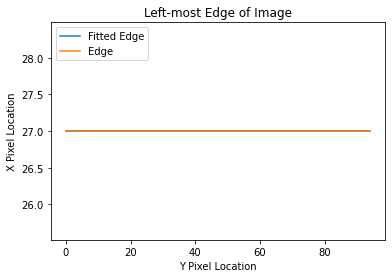

In [11]:
# Fit linear model
model = LinearRegression()
model.fit(x.reshape((-1, 1)), y.reshape((-1, 1)))

new_y = model.predict(x.reshape((-1, 1))).flatten()

fig, ax = plt.subplots()
ax.plot(x, new_y, label='Fitted Edge')
ax.plot(x, y, label='Edge')
ax.legend(loc='upper left')
ax.set_title('Left-most Edge of Image')
ax.set_xlabel('Y Pixel Location')
ax.set_ylabel('X Pixel Location')

### Get Angle from Slope
The slope and angle are 0, meaning the emitter is perfectly vertical.

In [12]:
print("Slope: ", model.coef_)
print("Angle: ", np.arctan(model.coef_), "radians")
print("Angle: ", np.degrees(np.arctan(model.coef_)), "degrees")

Slope:  [[0.]]
Angle:  [[0.]] radians
Angle:  [[0.]] degrees


## Full Function
Here is the function to determine angle of an object in an image

In [13]:
def find_angle(filename, y0, y1, x0, x1):
    """ Finds angle of an object using left-most edge in an image

    :param filename: filename of image
    :param y0: y coordinate of top left of bounding box of obj
    :param y1: y coordinate of bottom right of bounding box of obj
    :param x0: x coordinate of top left of bounding box of obj
    :param x1: x coordinate of botton right of bounding box of obj
    :return: angle of object in degrees
    """
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)  # Get image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale

    gray = gray[y0:y1, x0:x1]  # Crop image

    edges = cv2.Canny(gray, 100, 200)  # Edge detection
    edges = pd.DataFrame(edges)  # Putting edges in Dataframe

    edge = edges.idxmax(axis=1)  # Getting leftmost edge
    x = edge.index.values  # y pixel locations
    y = edge.values  # x pixel locations

    # Fitting linear model
    model = LinearRegression()
    model.fit(x.reshape((-1, 1)), y.reshape((-1, 1)))

    return np.degrees(np.arctan(model.coef_))  # Get angle from slope

### Known Misalignment

In [14]:
print(find_angle("image.jpg", 70, 250, 680, 830), "degrees")

[[4.39466635]] degrees


### Known Alignment

In [15]:
print(find_angle("image.jpg", 255, 350, 725, 800), "degrees")

[[0.]] degrees
